In [1]:
import os
import re
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

%matplotlib widget

In [2]:
M_earth = 5.972e24
R_earth = 6.371e6

In [3]:
# Directory containing the data files
data_dir = "../../output_files/"

# Regex to extract M and C from filenames
pattern = re.compile(r"planet_profile_M([\d\.]+)_C([\d\.]+)\.txt")

# Store data [[mass, core, radius], ...]
points = []

for fname in os.listdir(data_dir):
    match = pattern.match(fname)
    if match:
        M = float(match.group(1))
        C = float(match.group(2))

        data = np.loadtxt(data_dir+fname, delimiter=' ').T
        radius = float(data[0][-1])

        points.append([M, C, radius/R_earth])

points = np.array(points)
print(np.shape(points))

# Prepare data for plotting
mass_unique = np.unique(points.T[0])
core_unique = np.unique(points.T[1])

(100, 3)


In [36]:
def fit(mc, m0,m1, c0,c1, e0,e1, o1):
    m = mc[0]
    c = mc[1]
    return m0*m**m1 + c0*c**c1 + e0*(m*c)**e1 + o1

popt, pcov = curve_fit(fit, (points.T[0], points.T[1]), points.T[2])
print(popt)

[ 1.09386582  0.28185691 -0.20628905  2.07577957 -0.08740459  0.66950123
 -0.05188444]


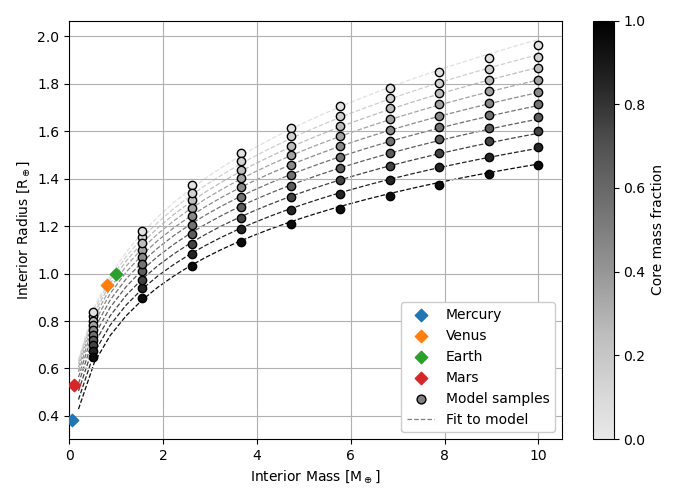

In [61]:

norm = mpl.colors.Normalize(vmin=-0.2, vmax=1)
sm = cm.ScalarMappable(norm=norm, cmap='Greys')

# Plot: for each mass and core fraction, give radius
fig,ax = plt.subplots(figsize=(7,5))
for p in points:
    x = p[0]
    y = p[2]
    col = sm.to_rgba(p[1])

    ax.scatter(x, y, color=col, zorder=2, edgecolors='k')

# Show fitted curve 
for c_tst in np.linspace(0.05, 0.95, 10):
    m_arr = np.linspace(0.2, 10.0, 30)
    r_arr = [fit((m,c_tst), *popt) for m in m_arr]
    ax.plot(m_arr,r_arr, color=sm.to_rgba(c_tst), ls='dashed', zorder=1, lw=0.9)


# Known planets (radius/km, mass/1e24kg)
# https://ssd.jpl.nasa.gov/planets/phys_par.html
planets = {
    "Mercury": [2439.4, 0.33010],
    "Venus":   [6051.8, 4.86731],
    "Earth":   [6371.0, 5.97217],
    "Mars":    [3389.5, 0.64169]
}
for p,v in planets.items():
    ax.scatter(v[1]*1e24/M_earth, v[0]*1e3/R_earth, label=p, zorder=6, s=40, marker='D')

ax.set_xlabel(r'Interior Mass [M$_\oplus$]')
ax.set_xlim(left=0)
ax.set_ylabel(r'Interior Radius [R$_\oplus$]')

ax.scatter([],[], s=40, color='grey', label="Model samples", edgecolors='k')
ax.plot(    [],[],lw=0.9, color='grey', label="Fit to model", ls='dashed')
ax.legend(framealpha=1, loc='lower right')

ax.grid(zorder=-4)

cb = fig.colorbar(sm, ax=ax, label="Core mass fraction")
cb.ax.set_ylim(bottom=0, top=1)

fig.tight_layout()
plt.show()